In [13]:
%matplotlib inline

import sys


from matplotlib import pylab as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

import itertools
import numpy
import scipy
import scipy.special
import time
import random

from ipywidgets import interact
from IPython.display import display, Markdown, clear_output

try:
    sys.path.append('../..')
   
    from crocodile.synthesis import *
    from crocodile.simulate import *
    from crocodile.antialias import *
    from util.visualize import *
    print("Crocodile Mode")
except:
    print("Standalone Mode")
    print("See crocodile repo for more information!")
    import numpy as np
    from scipy.optimize import leastsq, brent
    from json_tricks.np import load
    def coordinateBounds(N):
        r"""
        Returns lowest and highest coordinates of an image/grid given:

        1. Step size is :math:`1/N`:

           .. math:: \frac{high-low}{N-1} = \frac{1}{N}

        2. The coordinate :math:`\lfloor N/2\rfloor` falls exactly on zero:

           .. math:: low + \left\lfloor\frac{N}{2}\right\rfloor * (high-low) = 0

        This is the coordinate system for shifted FFTs.
        """
        if N % 2 == 0:
            return -0.5, 0.5 * (N - 2) / N
        else:
            return -0.5 * (N - 1) / N, 0.5 * (N - 1) / N

    def coordinates(N):
        """1D array which spans [-.5,.5[ with 0 at position N/2"""
        N2 = N // 2
        if N % 2 == 0:
            return numpy.mgrid[-N2:N2] / N
        else:
            return numpy.mgrid[-N2:N2+1] / N


    def coordinates2(N):
        """Two dimensional grids of coordinates spanning -1 to 1 in each
        dimension, with

        1. a step size of 2/N and
        2. (0,0) at pixel (floor(n/2),floor(n/2))

        :returns: pair (cx,cy) of 2D coordinate arrays
        """

        N2 = N // 2
        if N % 2 == 0:
            return numpy.mgrid[-N2:N2, -N2:N2][::-1] / N
        else:
            return numpy.mgrid[-N2:N2+1, -N2:N2+1][::-1] / N


    def fft(a):
        """ Fourier transformation from image to grid space

        :param a: image in `lm` coordinate space
        :returns: `uv` grid
        """
        if len(a.shape) == 1:
            return numpy.fft.fftshift(numpy.fft.fft(numpy.fft.ifftshift(a)))
        elif len(a.shape) == 2:
            return numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.ifftshift(a)))
        assert False, "Unsupported image shape for FFT!"


    def ifft(a):
        """ Fourier transformation from grid to image space

        :param a: `uv` grid to transform
        :returns: an image in `lm` coordinate space
        """
        if len(a.shape) == 1:
            return numpy.fft.fftshift(numpy.fft.ifft(numpy.fft.ifftshift(a)))
        elif len(a.shape) == 2:
            return numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(a)))
        assert False, "Unsupported grid shape for iFFT!"


    def pad_mid(ff, N):
        """
        Pad a far field image with zeroes to make it the given size.

        Effectively as if we were multiplying with a box function of the
        original field's size, which is equivalent to a convolution with a
        sinc pattern in the uv-grid.

        :param ff: The input far field. Should be smaller than NxN.
        :param N:  The desired far field size

        """

        N0 = ff.shape[0]
        if N == N0: return ff
        assert N > N0
        pad = [(N//2-N0//2, (N+1)//2-(N0+1)//2)]
        if len(ff.shape) == 2:
            assert N0 == ff.shape[1]
            pad = 2*pad # both dimensions
        return numpy.pad(ff, pad, mode='constant', constant_values=0.0)

    def extract_mid(a, N):
        """
        Extract a section from middle of a map

        Suitable for zero frequencies at N/2. This is the reverse
        operation to pad.

        :param a: grid from which to extract
        :param s: size of section
        """

        assert N <= a.shape[0]
        cx = a.shape[0] // 2
        s = N // 2
        if len(a.shape) == 2:
            assert N <= a.shape[1]
            cy = a.shape[1] // 2
            if N % 2 != 0:
                return a[cx - s:cx + s + 1, cy - s:cy + s + 1]
            else:
                return a[cx - s:cx + s, cy - s:cy + s]
        elif len(a.shape) == 1:
            if N % 2 != 0:
                return a[cx - s:cx + s + 1]
            else:
                return a[cx - s:cx + s]
        else:
            assert False, "Unsupported grid shape for extract_mid!"

    def extract_oversampled(a, Qpx, N):
        """
        Extract the (xf-th,yf-th) w-kernel from the oversampled parent

        Offsets are suitable for correcting of fractional coordinates,
        e.g. an offset of (xf,yf) results in the kernel for an (-xf,-yf)
        sub-grid offset.

        We do not want to make assumptions about the source grid's symetry
        here, which means that the grid's side length must be at least
        Qpx*(N+2) to contain enough information in all circumstances

        :param a: grid from which to extract
        :param Qpx: oversampling factor
        :param N: size of section
        """

        Na = a.shape[0]
        if len(a.shape) == 1:
            result = numpy.empty((Qpx, N), dtype=complex)
            for xf in range(Qpx):
                # Determine start offset.
                mx = Na//2 - Qpx*(N//2) + xf
                # Extract every Qpx-th pixel
                result[xf] = a[mx : mx+Qpx*N : Qpx]
            return result
        elif len(a.shape) == 2:
            result = numpy.empty((Qpx, Qpx, N, N), dtype=complex)
            for yf in range(Qpx):
                for xf in range(Qpx):
                    # Determine start offset.
                    my = Na//2 - Qpx*(N//2) + yf
                    mx = Na//2 - Qpx*(N//2) + xf
                    # Extract every Qpx-th pixel
                    result[yf,xf] = a[my : my+Qpx*N : Qpx,
                                      mx : mx+Qpx*N : Qpx]
            return result
        assert False, "Unsupported grid shape for extract_oversampled!"

    def anti_aliasing_function(shape, m, c):
        """
        Compute the prolate spheroidal anti-aliasing function

        See VLA Scientific Memoranda 129, 131, 132
        :param shape: (height, width) pair or just width
        :param m: mode parameter
        :param c: spheroidal parameter
        """

        # One dimensional?
        if len(numpy.array(shape).shape) == 0:

            # Remove one pixel on either side to prevent zeroes.
            mult = 2 - 1/shape/4
            return scipy.special.pro_ang1(m, m, c, mult*coordinates(shape))[0]

        # 2D Prolate spheroidal angular function is seperable
        return numpy.outer(anti_aliasing_function(shape[0], m, c),
                           anti_aliasing_function(shape[1], m, c))

    def kernel_transform(dl, dm):
        """Determine linear transformation matrix for a given shift that
        keeps w-kernel coordinates as constant as possible.

        To be precise: This returns a transformation matrix such that with

          (l',m') = T (l,m) + (dl,dm)

        We still have:

          sqrt(1-l'^2-m'^2) ~~ sqrt(1-l^2-m^2)

        As well as leaving l' and m' roughly aligned to l and m. This
        boils down to matching up the first-order terms of the series
        expansions (which are clearly zero for the right-hand term, as it
        is symmetric in both l and m).

        :param dl: Horizontal shift (directional cosine)
        :param dl: Vertical shift (directional cosine)
        :returns: A 2x2 transformation matrix
        """

        dn = numpy.sqrt(1-dl**2-dm**2)
        if dl != 0 or dm != 0:
            f = (dn-1) / (dl**2 + dm**2)
        else:
            f = 0
        return numpy.array([[dn-dm*dm*f,    dl*dm*f],
                            [   dl*dm*f, dn-dl*dl*f]])

    def kernel_coordinates(N, theta, dl=0, dm=0, T=None):
        """
        Returns (l,m) coordinates for generation of kernels
        in a far-field of the given size.

        If coordinate transformations are passed, they must be inverse to
        the transformations applied to the visibilities using
        visibility_shift/uvw_transform.

        :param N: Desired far-field resolution
        :param theta: Field of view size (directional cosines)
        :param dl: Pattern horizontal shift (see visibility_shift)
        :param dm: Pattern vertical shift (see visibility_shift)
        :param T: Pattern transformation matrix (see uvw_transform)
        :returns: Pair of (m,l) coordinates
        """

        l,m = coordinates2(N) * theta
        if not T is None:
            l,m = T[0,0]*l+T[1,0]*m, T[0,1]*l+T[1,1]*m


        return l+dl, m+dm


    def w_kernel_function(l, m, w):
        """W beam, the fresnel diffraction pattern arising from non-coplanar baselines

        For the w-kernel, shifting the kernel pattern happens to also
        shift the kernel depending on w. Use `kernel_recentre` to counter
        this effect and `visibility_recentre` to apply the reverse
        correction to visibilities.

        :param l: Horizontal image coordinates
        :param m: Vertical image coordinates
        :param N: Size of the grid in pixels
        :param w: Baseline distance to the projection plane
        :returns: N x N array with the far field

        """

        r2 = l**2 + m**2
        assert numpy.all(r2 < 1.0), "Error in image coordinate system: l %s, m %s" % (l, m)
        ph = 1 - numpy.sqrt(1.0 - r2)
        cp = numpy.exp(2j * numpy.pi * w * ph)
        return cp


    def kernel_recentre(cp, theta, w, dl, dm):
        """
        Re-center the kernel in grid-space by multiplying it by a phase
        ramp in image space, allowing us to reduce kernel support. Must be
        paired with `visibility_recentre` so that we end up with the same
        uv-grid in the end.

        :param cp: Kernel pattern
        :param w: w-plane of kernel
        :param dl: Horizontal shift to add
        :param dm: Vertical shift to add
        :returns: Re-centered kernel
        """
        N = cp.shape[0]
        l,m = coordinates2(N) * theta
        return cp * numpy.exp(-2j * numpy.pi * w * (dl * l + dm * m))


    def visibility_recentre(uvw, dl, dm):
        """
        Compensate for kernel re-centering - see `kernel_recentre`.

        :param uvw: Visibility coordinates
        :param dl: Horizontal shift to compensate for
        :param dm: Vertical shift to compensate for
        :returns: Visibility coordinates re-centred to the peak of their w-kernel
        """

        u, v, w = numpy.hsplit(uvw, 3)
        return numpy.hstack([u - w*dl,
                             v - w*dm,
                             w])


    def kernel_oversample(ff, Qpx, s=None):
        """
        Takes a farfield pattern and creates an oversampled convolution
        function.

        If the far field size is smaller than N*Qpx, we will pad it. This
        essentially means we apply a sinc anti-aliasing kernel by default.

        :param ff: Far field pattern
        :param Qpx: Factor to oversample by -- there will be Qpx x Qpx convolution arl
        :param s: Size of convolution function to extract
        :returns: Numpy array of shape [ov, ou, v, u], e.g. with sub-pixel
          offsets as the outer coordinates.
        """

        # Pad the far field to the required pixel size
        N = ff.shape[0]
        if s is None: s = N
        padff = pad_mid(ff, N*Qpx)

        # Obtain oversampled uv-grid
        af = fft(padff)

        # Extract kernels
        return extract_oversampled(af, Qpx, s)


    def w_kernel(theta, w, NpixFF, NpixKern, Qpx, invert=True, **kwargs):
        """
        The middle s pixels of W convolution kernel. (W-KERNel-Aperture-Function)

        :param theta: Field of view (directional cosines)
        :param w: Baseline distance to the projection plane
        :param NpixFF: Far field size. Must be at least NpixKern+1 if Qpx > 1, otherwise NpixKern.
        :param NpixKern: Size of convolution function to extract
        :param Qpx: Oversampling, pixels will be Qpx smaller in aperture
          plane than required to minimially sample theta.
        :param invert: Produce an inverted kernel (as required for imaging)

        :returns: [Qpx,Qpx,s,s] shaped oversampled convolution kernels
        """
        assert NpixFF > NpixKern or (NpixFF == NpixKern and Qpx == 1)

        l,m = kernel_coordinates(NpixFF, theta, **kwargs)
        kern = w_kernel_function(l,m,w)
        if invert:
            kern = 1 / kern
        return kernel_oversample(kern, Qpx, NpixKern)


    def invert_kernel(a):
        """
        Pseudo-Invert a kernel: element-wise inversion (see RauThesis2010:Eq4.6)

        NOT USED
        """
        return numpy.conj(a) / (numpy.abs(a) ** 2)


    def grid(a, p, v):
        """Grid visibilities (v) at positions (p) into (a) without convolution

        :param a:   The uv plane to grid to (updated in-place!)
        :param p:   The coordinates to grid to (in fraction [-.5,.5[ of grid)
        :param v:   Visibilities to grid
        """
        assert numpy.max(p) < 0.5

        N = a.shape[0]
        xy = N//2 + numpy.floor(0.5 + N * p[:,0:2]).astype(int)
        for (x, y), v in zip(xy, v):
            a[y, x] += v


    def degrid(a, p):
        """DeGrid visibilities (v) at positions (p) from (a) without convolution

        :param a:   The uv plane to de-grid from
        :param p:   The coordinates to degrid at (in fraction of grid)
        :returns: Array of visibilities.
        """
        assert numpy.max(p) < 0.5

        N = a.shape[0]
        xy = N//2 + numpy.floor(0.5 + p[:,0:2] * N).astype(int)
        v = [ a[y,x] for x,y in xy ]
        return numpy.array(v)


    def frac_coord(N, Qpx, p):
        """
        Compute whole and fractional parts of coordinates, rounded to
        Qpx-th fraction of pixel size

        The fractional values are rounded to nearest 1/Qpx pixel value. At
        fractional values greater than (Qpx-0.5)/Qpx coordinates are
        roundeded to next integer index.

        :param N: Number of pixels in total
        :param Qpx: Fractional values to round to
        :param p: Coordinate in range [-.5,.5[
        """
        assert (p >= -0.5).all() and (p < 0.5).all()
        x = N//2 + p * N
        fx = numpy.around(-x * Qpx).astype(int)
        return -(fx // Qpx), fx % Qpx


    def frac_coords(shape, Qpx, p):
        """Compute grid coordinates and fractional values for convolutional
        gridding

        :param shape: (height,width) grid shape
        :param Qpx: Oversampling factor
        :param p: array of (x,y) coordinates in range [-.5,.5[
        """
        h, w = shape # NB order (height,width) to match numpy!
        x, xf = frac_coord(w, Qpx, p[:,0])
        y, yf = frac_coord(h, Qpx, p[:,1])
        return x,xf, y,yf

    def make_gcf(src, gcf):

        src = numpy.array(src)
        if len(gcf.shape) - src.shape[1] == 2:
            Qpx, gw = gcf.shape[-2:]
            return Qpx, gw, gw, lambda s, xf, yf: numpy.outer(gcf[(*s, yf)], gcf[(*s, xf)])
        elif len(gcf.shape) - src.shape[1] == 4:
            Qpx, gh, gw = gcf.shape[-3:]
            return Qpx, gw, gh, lambda s, xf, yf: gcf[(*s, yf, xf)]
        else:
            assert False


    def convgrid(gcf, a, p, src, v):
        """Grid after convolving with gcf

        Takes into account fractional `uv` coordinate values where the GCF
        is oversampled.

        :param a: Grid to add to
        :param p: UVW positions
        :param v: Visibility values
        :param gcf: Oversampled convolution kernel
        """

        if src is None: src = numpy.zeros((p.shape[0], 0))
        Qpx, gh, gw, mk_gcf = make_gcf(src, gcf)
        coords = frac_coords(a.shape, Qpx, p)
        for v, s, x,xf, y,yf in zip(v, src, *coords):
            a[y-gh//2 : y+(gh+1)//2,
              x-gw//2 : x+(gw+1)//2] += mk_gcf(s,xf,yf) * v


    def convdegrid(gcf, a, p, src=None):
        """Convolutional degridding

        Takes into account fractional `uv` coordinate values where the GCF
        is oversampled

        :param gcf: Oversampled convolution kernel
        :param a:   The uv plane to de-grid from
        :param p:   The coordinates to degrid at.
        :param src: Visibility source information
        :returns:   Array of visibilities.
        """

        if src is None: src = numpy.zeros((p.shape[0], 0))
        Qpx, gw, gh, mk_gcf = make_gcf(src, gcf)
        coords = frac_coords(a.shape, Qpx, p)
        return numpy.array([
           numpy.sum(a[y-gh//2 : y+(gh+1)//2,
                       x-gw//2 : x+(gw+1)//2] * mk_gcf(s, xf, yf))
           for s, x,xf, y,yf in zip(src, *coords)])


    def sort_vis_w(p, v=None):
        """Sort visibilities on the w value.
        :param p: uvw coordinates
        :param v: Visibility values (optional)
        """
        zs = numpy.argsort(p[:, 2])
        if v is not None:
            return p[zs], v[zs]
        else:
            return p[zs]


    def slice_vis(step, uvw, v=None):
        """ Slice visibilities into a number of chunks.

        :param step: Maximum chunk size
        :param uvw: uvw coordinates
        :param src: visibility source
        :param v: Visibility values (optional)
        :returns: List of visibility chunk (pairs)
        """
        nv = len(uvw)
        ii = range(0, nv, step)
        if v is None:
            return [ uvw[i:i+step] for i in ii ]
        else:
            return [ (uvw[i:i+step], v[i:i+step]) for i in ii ]


    def doweight(theta, lam, p, v):
        """Re-weight visibilities

        Note that as is usual, convolution kernels are not taken into account
        """
        N = int(round(theta * lam))
        assert N > 1
        gw = numpy.zeros([N, N])
        x, xf, y, yf = frac_coords(gw.shape, 1, p / lam)
        for i in range(len(x)):
            gw[x[i], y[i]] += 1
        v = v.copy()
        for i in range(len(x)):
            v[i] /= gw[x[i], y[i]]
        return v


    def simple_imaging(theta, lam, uvw, src, vis):
        """Trivial function for imaging

        Does no convolution but simply puts the visibilities into a grid
        cell i.e. boxcar gridding
        """
        N = int(round(theta * lam))
        assert N > 1
        guv = numpy.zeros([N, N], dtype=complex)
        grid(guv, uvw / lam, vis)
        return guv


    def simple_predict(theta, lam, uvw, src, guv):
        """Trivial function for degridding

        Does no convolution but simply extracts the visibilities from a grid cell i.e. boxcar degridding

        :param theta: Field of view (directional cosines)
        :param lam: Maximum uv represented in the grid
        :param uvw: UVWs of visibilities
        :param src: Visibility source information (ignored)
        :param guv: Input u/v grid
        :returns: p, v
        """
        N = int(round(theta * lam))
        assert N > 1
        v = degrid(guv, uvw / lam)
        return v


    def conv_imaging(theta, lam, uvw, src, vis, kv):
        """Convolve and grid with user-supplied kernels

        :param theta: Field of view (directional cosines))
        :param lam: UV grid range
        :param uvw: UVWs of visibilities
        :param src: Visibility source information
        :param vis: Visibility values
        :param kv: Gridding kernel
        :returns: UV grid
        """
        N = int(round(theta * lam))
        assert N > 1
        guv = numpy.zeros([N, N], dtype=complex)
        convgrid(kv, guv, uvw / lam, src, vis)
        return guv

    def conv_predict(theta, lam, uvw, src, guv, kv):
        """Convolve and grid with user-supplied kernels

        :param theta: Field of view (directional cosines))
        :param lam: UV grid range
        :param uvw: UVWs of visibilities
        :param src: Visibility source information
        :param guv: UV grid
        :param kv: Gridding kernel
        :returns: visibility values
        """

        if src is None: src = numpy.ndarray((len(uvw), 0))
        return convdegrid(kv, guv, uvw / lam, src)


    def w_slice_imaging(theta, lam, uvw, src, vis,
                        wstep=2000,
                        kernel_fn=w_kernel,
                        **kwargs):
        """Basic w-projection imaging using slices

        Sorts visibility by w value and splits into equally sized slices.
        W-value used for kernels is mean w per slice. Uses the same size
        for all kernels irrespective of w.

        :param theta: Field of view (directional cosines)
        :param lam: UV grid range (wavelenghts)
        :param uvw: UVWs of visibilities (wavelenghts)
        :param src: Visibility source information
        :param vis: Visibility values
        :param wstep: Size of w-slices
        :param kernel_fn: Function for generating the kernels. Parameters
          `(theta, w, *ant, **kwargs)`. Default `w_kernel`.
        :returns: UV grid
        """
        N = int(round(theta * lam))
        assert N > 1
        slices = slice_vis(wstep, *sort_vis_w(p, v))
        guv = numpy.zeros([N, N], dtype=complex)
        for ps, vs in slices:
            w = numpy.mean(ps[:, 2])
            wg = kernel_fn(theta, w, **kwargs)
            convgrid(wg, guv, ps / lam, src, vs)
        return guv


    def w_slice_predict(theta, lam, uvw, src, guv,
                        wstep=2000,
                        kernel_fn=w_kernel,
                        **kwargs):
        """Basic w-projection predict using w-slices

        Sorts visibility by w value and splits into equally sized slices.
        W-value used for kernels is mean w per slice. Uses the same size
        for all kernels irrespective of w.

        :param theta: Field of view (directional cosines)
        :param lam: UV grid range (wavelenghts)
        :param uvw: UVWs of visiblities
        :param src: Visibility source information
        :param guv: Input uv grid to de-grid from
        :param wstep: Size of w-slices
        :param kernel_fn: Function for generating the kernels. Parameters
          `(theta, w, **kwargs)`. Default `w_kernel`.
        :returns: Visibilities, same order as p
        """
        # Calculate number of pixels in the Image
        N = int(round(theta * lam))
        assert N > 1
        # Sort the u,v,w coordinates. We cheat a little and also pass
        # visibility indices so we can easily undo the sort later.
        nv = len(p)
        slices = slice_vis(wstep, *sort_vis_w(p, numpy.arange(nv)))
        v = numpy.ndarray(nv, dtype=complex)
        for ps, ixs in slices:
            w = numpy.mean(ps[:, 2])
            wg = kernel_fn(theta, w, **kwargs)
            v[ixs] = convdegrid(wg, guv, ps / lam)
        return v


    def w_conj_kernel_fn(kernel_fn):
        """Wrap a kernel function for which we know that

           kernel_fn(w) = conj(kernel_fn(-w))

        Such that we only evaluate the function for positive w. This is
        benificial when the underlying kernel function does caching, as it
        improves the cache hit rate.

        :param kernel_fn: Kernel function to wrap
        :returns: Wrapped kernel function
        """

        def fn(theta, w, *args, **kw):
            if w < 0:
                return numpy.conj(kernel_fn(theta, -w, *args, **kw))
            return kernel_fn(theta, w, *args, **kw)
        return fn

    def aw_kernel_fn(a_kernel_fn, w_kernel_fn=w_kernel):
        """
        Make a kernel function to generate AW kernels.

        This convolves three kernels for every AW-kernel: Two A-kernels
        for either antenna and the w-kernel.

        We expect the two first columns of "src" to identify the two
        antennas involved in a baseline.

        :param akernel_fn: Function to generate A-kernels. Parameters
          (theta, ant, time, freq)
        :param wkernel_fn: Function to generate w-kernels. Parameters
          (theta, w)
        :returns: Kernel function to generate AW-kernels

        """

        def fn(theta, w, a1, a2, *src):

            # Convolve antenna A-kernels
            a1kern = a_kernel_fn(theta, a1, *src)
            a2kern = a_kernel_fn(theta, a2, *src)
            akern = scipy.signal.convolve2d(a1kern, a2kern, mode='same')

            # Convolve with all oversampling values to obtain Aw-kernel
            # (note that most oversampling sub-grid values will end up unused!)
            wkern = w_kernel_fn(theta, w)
            awkern = [[scipy.signal.convolve2d(akern, wk, mode='same')
                       for wk in wks]
                      for wks in wkern]
            return numpy.array(awkern)

        return fn

    def sample_image(image, x, y):
        """ Sample image at given position(s), relative to middle of image.

        Performs simple bilinear interpolation if positions are not even numbers.

        :param image: Image to sample
        :param x: Horizontal sampling coordinates
        :param y: Vertical sampling coordinates
        """

        # Make positions relative to image middle
        x += image.shape[0]/2
        y += image.shape[1]/2
        # Crude linear sampling
        ix = numpy.floor(x).astype(int); dx = x - ix
        iy = numpy.floor(y).astype(int); dy = y - iy
        return numpy.sum([image[iy,   ix]  *((1-dx)*(1-dy)),
                          image[iy,   ix+1]*(   dx *(1-dy)),
                          image[iy+1, ix]  *((1-dx)*   dy ),
                          image[iy+1, ix+1]*(   dx *   dy )], axis=0)

    def w_cache_imaging(theta, lam, uvw, src, vis,
                        wstep=2000,
                        kernel_cache=None,
                        kernel_fn=w_kernel,
                        **kwargs):
        """Basic w-projection by caching convolution arl in w

        A simple cache can be constructed externally and passed in:

          kernel_cache = pylru.FunctionCacheManager(w_kernel, cachesize)

        If applicable, consider wrapping in `w_conj_kernel_fn` to improve
        effectiveness further.

        :param theta: Field of view (directional cosines)
        :param lam: UV grid range (wavelenghts)
        :param uvw: UVWs of visibilities (wavelengths)
        :param src: Visibility source information (various)
        :param vis: Visibilites to be imaged
        :param wstep: Size of w-bins (wavelengths)
        :param kernel_cache: Kernel cache. If not passed, we fall back
           to `kernel_fn`.
        :param kernel_fn: Function for generating the kernels. Parameters
           `(theta, w, **kwargs)`. Default `w_kernel`.
        :returns: UV grid

        """

        # Construct default cache, if needed. As visibilities are
        # traversed in w-order it only needs to hold the last w-kernel.
        if kernel_cache is None:
            kernel_cache = pylru.FunctionCacheManager(kernel_fn, 1)

        N = int(round(theta * lam))
        guv = numpy.zeros([N, N], dtype=complex)
        for p, s, v in zip(uvw, src, vis):
            wbin = wstep * numpy.round(p[2] / wstep)
            wg = kernel_cache(theta, wbin, *s, **kwargs)
            convgrid(wg, guv, numpy.array([p / lam]), [()], numpy.array([v]))
        return guv


    def w_cache_predict(theta, lam, uvw, src, guv,
                        wstep=2000,
                        kernel_cache=None,
                        kernel_fn=w_kernel,
                        **kwargs):
        """Predict visibilities using w-kernel cache

        :param theta: Field of view (directional cosines)
        :param lam: UV grid range (wavelenghts)
        :param uvw: UVWs of visibilities  (wavelengths)
        :param guv: Input uv grid to de-grid from
        :param wstep: Size of w-bins (wavelengths)
        :param kernel_cache: Kernel cache. If not passed, we fall back
           to `kernel_fn`. See `w_cache_imaging` for details.
        :param kernel_fn: Function for generating the kernels. Parameters
           `(theta, w, **kwargs)`. Default `w_kernel`.
        :returns: degridded visibilities
        """

        if kernel_cache is None:
            kernel_cache = pylru.FunctionCacheManager(kernel_fn, 1)
        def kernel_binner(theta, w, **kw):
            wbin = wstep * numpy.round(w / wstep)
            return kernel_cache(theta, wbin, **kw)
        v = numpy.ndarray(nv, dtype=complex)
        for p, s in zip(uvw, src):
            wbin = wstep * numpy.round(p[2] / wstep)
            wg = kernel_cache(theta, wbin, *s, **kwargs)
            v[ixs] = convdegrid(wg, guv, numpy.array([p / lam]))
        return v


    def mirror_uvw(uvw, vis):
        """Mirror uvw with v<0 such that all visibilities have v>=0

        The result visibilities will be equivalent, as every baseline
        `a->b` has a "sister" baseline `b->a` with a complex-conjugate
        value. A dataset typically only contains one of the two, so here
        we simply choose visibilities that lie in one half of the grid.

        :param uvw: UVWs of visibilities
        :param vis: Visibilities
        :returns: new uvw, vis
        """

        # Determine indices with v<1, make copies to update
        vn = uvw[:,1] < 0
        uvw = numpy.copy(uvw)
        vis = numpy.copy(vis)

        # Flip coordinates and conjugate visibilities
        uvw[vn] = -uvw[vn]
        vis[vn] = numpy.conj(vis[vn])
        return uvw, vis


    def make_grid_hermitian(guv):
        """
        Make a grid "hermitian" by adding it to its own conjugated mirror
        image.

        Just as baselines can be seen from two sides, the grid is
        "hermitian": Mirrored coordinates yield complex-conjugate
        uv-cells. However in practice, it is less computationally
        intensive to just grid one of each baseline pair, and then restore
        the hermitian property afterwards.

        :param guv: Input grid
        :returns: Hermitian grid
        """

        # Make mirror image, then add its conjugate to the original grid.
        # This is not the same concept as hermitian matrices, as:
        #  1) Not the same symetry as transposition
        #  2) We mirror on the zero point, which is off-center if the grid
        #     has even size
        if guv.shape[0] % 2 == 0:
            guv[1:,1:] += numpy.conj(guv[:0:-1,:0:-1])
            # Note that we ignore the high frequencies here
        else:
            guv += numpy.conj(guv[::-1,::-1])
        return guv


    def do_imaging(theta, lam, uvw, src, vis, imgfn, **kwargs):

        """Do imaging with imaging function (imgfn)

        :param theta: Field of view (directional cosines)
        :param lam: UV grid range (wavelenghts)
        :param uvw: UVWs of visibilities (wavelengths)
        :param ant: Visibility source information (various)
        :param vis: Visibilities to be imaged
        :param imgfn: imaging function e.g. `simple_imaging`, `conv_imaging`,
          `w_slice_imaging` or `w_cache_imaging`. All keyword parameters
          are passed on to the imaging function.
        :returns: dirty Image, psf
        """
        if src is None: src = numpy.ndarray((len(vis), 0))
        # Mirror baselines such that v>0
        uvw,vis = mirror_uvw(uvw, vis)
        # Determine weights
        wt = doweight(theta, lam, uvw, numpy.ones(len(uvw)))
        # Make image
        cdrt = imgfn(theta, lam, uvw, src, wt * vis, **kwargs)
        drt = numpy.real(ifft(make_grid_hermitian(cdrt)))
        # Make point spread function
        c = imgfn(theta, lam, uvw, src, wt, **kwargs)
        psf = numpy.real(ifft(make_grid_hermitian(c)))
        # Normalise
        pmax = psf.max()
        assert pmax > 0.0
        return drt / pmax, psf / pmax, pmax


    def do_predict(theta, lam, uvw, src, modelimage, predfn, **kwargs):
        """Predict visibilities for a model Image at the phase centre using the
        specified degridding function.

        :param theta: Field of view (directional cosines)
        :param lam: UV grid range (wavelenghts)
        :param uvw: UVWs of visiblities (wavelengths)
        :param modelimage: model image as numpy.array (phase center at Nx/2,Ny/2)
        :param predfn: prediction function e.g. `simple_predict`,
          `w_slice_predict` or `w_cache_predict`.
        :returns: predicted visibilities
        """
        ximage = fft(modelimage.astype(complex))
        return predfn(theta, lam, uvw, src, ximage, **kwargs)


    
    print("The optimal gridding code is from Sze-Tan Meng")
    # Load kernel cache
    KERNEL_CACHE = {}
    with open('gridder.json', 'r') as f:
        for key, val in load(f):
            KERNEL_CACHE[tuple(key[0])] = val

    def trap(vec, dx):
        # Perform trapezoidal integration
        return dx * (numpy.sum(vec) - 0.5 * (vec[0] + vec[-1]))

    def func_to_min(h, x0, M, R):
        N = len(h)
        nu = (np.arange(M, dtype=float) + 0.5) / (2 * M)
        x = x0 * np.arange(N+1, dtype=float)/N
        C = calc_gridder_as_C(h, x0, nu, R)
        dnu = nu[1] - nu[0]
        dx = x[1] - x[0]
        h_ext = np.concatenate(([1.0], h))
        loss = np.zeros((len(h_ext), 2, M), dtype=float)
        for n, x_val in enumerate(x):
            one_app = 0
            for r in range(0, 2 * R):
                l = r - R + 1
                one_app += h_ext[n] * C[r, :] * np.exp(2j * np.pi * (l - nu) * x_val)
            loss[n, 0, :] = 1.0 - np.real(one_app)
            loss[n, 1, :] = np.imag(one_app)
            if n in [0, N]:
                loss[n, :, :] /= np.sqrt(2)
        loss = loss.reshape(2 * M * (N + 1))
        return loss

    def optimal_grid(R, x0, N, M, h_initial=None):
        if h_initial is None:
            h_initial = np.ones(N, dtype=float)
        return leastsq(func_to_min, h_initial, args=(x0, M, R), full_output=True)

    def find_cached_kernel(R, x0,  N=32, M=64, max_dx0=1/16):
        """ Returns the key for a cached gridder with th given parameters

        :param R: Half support in pixels
        :param x0: Image plane coordinates up to which coordinates are optimised
        :param N: Number of points to evaluate in image space
        :param M: Number of sub-grid points to evaluate in grid space (oversampling)
        :param max_dx0: Difference in x0 to accept when using cached kernel
        """

        # First try to look up directly
        key = (R, x0, N, M)
        if key in KERNEL_CACHE:
            return key

        # Then try to find next best one
        best = None
        dx0 = 1e15
        for kp in KERNEL_CACHE.keys():
            Rp, x0p, Np, Mp = kp

            # R must match, x0 difference must be at least as good
            if Rp != R: continue
            if abs(x0p - x0) > dx0: continue

            # Otherwise select by quality of optimisation
            if abs(x0p - x0) == dx0:
                if Np < best[2] or Mp < best[3]:
                    continue
            best = kp
            dx0 = abs(x0p - x0)

        return best

    def optimal_grid_cached(R, x0, N=32, M=64, max_dx0=1/16, h_initial=None):
        """ Returns an optimal gridder for the given parameters.

        :param R: Half support in pixels
        :param x0: Image plane coordinates up to which coordinates are optimised
        :param N: Number of points to evaluate in image space
        :param M: Number of sub-grid points to evaluate in grid space (oversampling)
        :param max_dx0: Difference in x0 to accept when using cached kernel
        """
        assert R >= 1
        assert x0 < 0.5

        # Best one good enough?
        best = find_cached_kernel(R, x0, N, M, max_dx0)
        if best is not None:
            Rp, x0p, Np, Mp = best
            if x0p >= x0 and x0p - x0 <= max_dx0 and Np >= N and Mp >= M:
                return KERNEL_CACHE[best]

        # Have one that is at least close enough for an initial solution?
        h_initial = None
        if best is not None:
            Rp, x0p, Np, Mp = best
            if abs(x0p - x0) <= max_dx0:
                x = x0 * (1 + np.arange(0, N, dtype=float))/N
                h_initial = calc_gridding_correction_fine(x, KERNEL_CACHE[best]['h'], x0p, M, Rp)

        # As last resort, use one with less support
        if h_initial is None:
            if R == 3:
                h_initial = optimal_grid_cached(R-1,x0,N,M, max_dx0)['h']
            elif R >= 4:
                h0 = optimal_grid_cached(R-2,x0,N,M, max_dx0)['h']
                h1 = optimal_grid_cached(R-1,x0,N,M, max_dx0)['h']
                h_initial = h1 * (h1/h0)

        # Run optimisation
        key = (R, x0, N, M)
        print("Calculating", key)
        h, cov_h, infodict, mesg, ler = optimal_grid(R, x0, N, M, h_initial)
        if ler == 0:
            return None

        # Determine error
        mean_map_err = calc_mean_map_error(x0, N, M, R, h)
        print("Mean map error: %g" % mean_map_err)

        # Make & cache result
        result = {"R": R, "x0":x0, "h":h, "err":mean_map_err}
        KERNEL_CACHE[key] = result
        return result

    def calc_gridder_as_C(h, x0, nu, R):
        # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1. 
        #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
        # The gridding function is calculated for l=-R+1 to R at points nu
        M = len(nu)
        C = np.zeros((2*R, M), dtype=float)
        K = np.zeros((2*R, 2*R))
        N = len(h)
        x = x0 * np.arange(0, N+1, dtype=float)/N
        dx = x0 / N
        h_ext = np.concatenate(([1.0], h))

        for rp in range(0, 2 * R):
            lp = rp - R + 1
            for r in range(2 * R):
                l = r - R + 1
                K[rp, r] = trap((h_ext**2) * np.cos(2 * np.pi * (lp - l) * x), dx)
        #Kinv = np.linalg.pinv(K)

        rhs = np.zeros(2*R, dtype=float)
        for m, nu_val in enumerate(nu):
            for rp in range(0, 2 * R):
                lp = rp - R + 1
                rhs[rp] = trap(h_ext * np.cos(2 * np.pi * (lp - nu_val) * x), dx)
            C[:,m] = np.linalg.lstsq(K, rhs, 1e-14)[0]
            # C[:,m] = np.dot(Kinv, rhs)
        return C

    def make_evaluation_grids(R, M, N):
        """Generate vectors nu and x on which the gridder and gridding correction functions need to be evaluated.
            R is the number of integer gridpoints on each side of the data point
            M determines the sampling of the nu grid, dnu = 1/(2*M)
            N determines the sampling of the x grid, dx = 1/(2*N)
        """
        nu = (numpy.arange(2 * R * M, dtype=float) + 0.5) / (2 * M)
        x = numpy.arange(N+1, dtype=float)/(2*N)
        return nu, x

    def calc_gridder(h, x0, nu, M, R):
        # Calculate gridder function on a grid nu which should have been generated using make_evaluation_grids
        #  The array h is the result of an optimization process for the gridding correction function evaluated
        #  on a relatively coarse grid extending from 0 to x0
        C = calc_gridder_as_C(h, x0, nu, R)
        gridder = np.zeros(2*M*R, dtype=float)
        for m in range(M):
            for rp in range(0, 2 * R):
                lp = rp - R + 1
                indx = m - 2*lp*M
                if indx >= 0:
                    gridder[indx] = C[rp, m]
                else:
                    gridder[-indx-1] = C[rp, m]
        return gridder

    # The functions with the "_fine" suffix allow the convolution function
    # C and the gridding correction function h to be evaluated at
    # arbitrary points, rather than at only the points which were used in
    # performing the optimization

    def calc_gridding_fine(h, x0, nu, R):
        # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1.
        #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
        # The gridding function is calculated for l=-R+1 to R at points nu
        M = len(nu)
        C = numpy.zeros((2*R, M), dtype=float)
        K = numpy.zeros((2*R, 2*R))
        N = len(h)
        x = x0 * numpy.arange(0, N+1, dtype=float)/N
        dx = x0 / N
        h_ext = numpy.concatenate(([1.0], h))

        for rp in range(0, 2 * R):
            lp = rp - R + 1
            for r in range(2 * R):
                l = r - R + 1
                K[rp, r] = trap((h_ext**2) * numpy.cos(2 * numpy.pi * (lp - l) * x), dx)
        Kinv = numpy.linalg.inv(K)

        rhs = numpy.zeros(2*R, dtype=float)
        for m, nu_val in enumerate(nu):
            for rp in range(0, 2 * R):
                lp = rp - R + 1
                rhs[rp] = trap(h_ext * numpy.cos(2 * numpy.pi * (lp - nu_val) * x), dx)
            C[:,m] = numpy.dot(Kinv, rhs)
        return C

    def gridder_to_C(gridder, R):
        """Reformat gridder evaluated on the nu grid returned by make_evaluation_grids into the sampled C function
           which has an index for the closest gridpoint and an index for the fractional distance from that gridpoint
        """
        M = len(gridder) // (2 * R)
        C = np.zeros((2 * R, M), dtype=float)
        for r in range(0, 2 * R):
            l = r - R + 1
            indx = np.arange(M) - 2 * M * l
            # Use symmetry to deal with negative indices
            indx[indx<0] = -indx[indx<0] - 1
            C[r, :] = gridder[indx]
        return C

    def calc_gridding_correction_fine(x, h, x0, M, R):
        nu = (numpy.arange(M, dtype=float) + 0.5) / (2 * M)
        C = calc_gridding_fine(h, x0, nu, R)
        nu = (numpy.arange(M, dtype=float) + 0.5) / (2 * M)
        dnu = 1.0 / (2 * M)
        c = numpy.zeros(x.shape, dtype=float)
        d = numpy.zeros(x.shape, dtype=float)
        for n, x_val in enumerate(x):
            for rp in range(0, 2 * R):
                lp = rp - R + 1
                for r in range(2 * R):
                    l = r - R + 1
                    d[n] += numpy.sum(C[rp, :] * C[r, :] * numpy.cos(2 * numpy.pi * (lp - l) * x_val)) * dnu
                c[n] += numpy.sum(C[rp, :] * numpy.cos(2 * numpy.pi * (lp - nu) * x_val)) * dnu
        hfine = c/d
        return hfine

    def calc_map_error(gridder, grid_correction, nu, x, R):
        M = len(nu) // (2 * R)
        N = len(x) - 1
        dnu = nu[1] - nu[0]
        C = gridder_to_C(gridder, R)
        loss = np.zeros((len(x), 2, M), dtype=float)
        for n, x_val in enumerate(x):
            one_app = 0
            for r in range(0, 2 * R):
                l = r - R + 1
                one_app += grid_correction[n] * C[r, :] * np.exp(2j * np.pi * (l - nu[:M]) * x_val)
            loss[n, 0, :] = 1.0 - np.real(one_app)
            loss[n, 1, :] = np.imag(one_app)
        map_error = np.zeros(len(x), dtype=float)
        for i in range(len(x)):
            map_error[i] = 2 * np.sum((loss[i, :, :].flatten())**2) * dnu
        return map_error

    def calc_mean_map_error(x0, N, M, R, h):
        nu, x = make_evaluation_grids(R, M, N)
        gridder = calc_gridder(h, x0, nu, M, R)
        grid_correction = calc_gridding_correction_fine(x, h, x0, M, R)
        map_err = calc_map_error(gridder, grid_correction, nu, x, R)
        which = np.digitize(x0, x)
        return numpy.sqrt( trap(map_err[:which], 1.0/(2*N)) / x[which] )

    def sze_tan_grid_correction(R, x0, image_size, Nopt=64, Mopt=32, max_dx0=1/16):
        """ Generate a Sze-Tan grid correction pattern in crocodile coordinate system
        :param R: Half-support of kernel
        :param x0: Significant part of image
        :param grid_size: Size of pattern to create
        :param Nopt: Number of points to evaluate in image space
        :param Mopt: Number of sub-grid points to evaluate in grid space (oversampling)
        :param max_dx0: Difference in x0 to accept when using cached kernel
        """
        grid = optimal_grid_cached(R, x0, Nopt, Mopt, max_dx0)
        return sze_tan_grid_correction_gen(R, x0, coordinates(image_size), Nopt, Mopt, max_dx0)

    def sze_tan_grid_correction_gen(R, x0, x, Nopt=64, Mopt=32, max_dx0=1/16):
        """ Generate a Sze-Tan grid correction pattern for arbitrary image coordinates
        :param R: Half-support of kernel
        :param x0: Significant part of image
        :param x: Image coordinates
        :param Nopt: Number of points to evaluate in image space
        :param Mopt: Number of sub-grid points to evaluate in grid space (oversampling)
        :param max_dx0: Difference in x0 to accept when using cached kernel
        """
        grid = optimal_grid_cached(R, x0, Nopt, Mopt, max_dx0)
        grid_correction = calc_gridding_correction_fine(numpy.array(x), grid['h'], grid['x0'], len(x), R)
        return 1 / grid_correction

    def sze_tan_gridder(R, x0, over, Nopt=64, Mopt=32, max_dx0=1/16):
        grid = optimal_grid_cached(R, x0, Nopt, Mopt, max_dx0)

        # Generate gridder in crocodile coordinate system
        nu = numpy.arange(over, dtype=float) / over
        gridding = calc_gridding_fine(grid['h'], grid['x0'], nu, R)
        return numpy.transpose(gridding[::-1])

    def sze_tan_mean_error(R, x0, Nopt=64, Mopt=32, max_dx0=1/16):
        grid = optimal_grid_cached(R, x0, Nopt, Mopt, max_dx0)
        return calc_mean_map_error(x0, Nopt, Mopt, R, grid['h'])


Standalone Mode
See crocodile repo for more information!
The optimal gridding code is from Sze-Tan Meng


In [14]:
theta = 2.0
lam = 32
grid_size = int(theta*lam)

# Convert Locations to u/v/w from metres
cfreq = 74029999.9919
wl = 3e8/cfreq

In [15]:
#print(locations_uvw)

# Simulate Electric Field

We really want to simulate instead of use real data here, so we can generate the absolute worst possible antenna distribution and show we are able to recover an image by the FFT algorithm.

In [79]:
def simulate_electric_fields_coplanar(locations_uvw,points):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(256):
        for point in points:
            elec_ss[i] += point[2]*numpy.exp(2j*numpy.pi*(locations_uvw[i,0]*point[0]+locations_uvw[i,1]*point[1]))
    return elec_ss

def simulate_electric_fields(locations_uvw,points):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(256):
        for point in points:
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            amp = point[2]
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(2j*numpy.pi*(u*l+v*m+w*n))
    return elec_ss

def calculate_gaussian_volume_of_points(antenna_number):   
    return (numpy.random.randn(antenna_number,3)-0.5)*8
    
def epic_image_snapshot(efield,locations):
    grid = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)    
    location_grid_points = locations

    for j,efieldd in enumerate(efield):
            grid[location_grid_points[j,0],location_grid_points[j,1]] += efieldd

    imaged = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid),s=(grid_size,grid_size)))
    imaged = imaged * imaged.conj()
    image += imaged
    grid[...] = 0.0
        
    #plt.imshow(grid.real)
    #plt.show()
    #image = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid)))
    #imsq = image * image.conj()
    return image
     
def plot_celestial_sphere(image,title='Celestial Sphere'):
    
    xticks = (numpy.arange(image.shape[0])/image.shape[0]  * theta) - theta/2
    yticks = xticks.copy()
    
    lm_coord = [0,image.shape[0]//2,image.shape[0]]
    
    
    fig,ax = plt.subplots(figsize=(5,5))
    s= ax.imshow(numpy.abs(image))
    ax.set_xticks(lm_coord)
    ax.set_xticklabels([-1,0,1])
    ax.set_yticks(lm_coord)
    ax.set_yticklabels([-1,0,1])
    fig.colorbar(s,ax=ax)
    ax.set_title(title)
    ax.set_xlabel("l")
    ax.set_ylabel("m")
    
    plt.show()

# Now let us try with a gaussian cube of electric field locations

Text(0.5, 0, 'w')

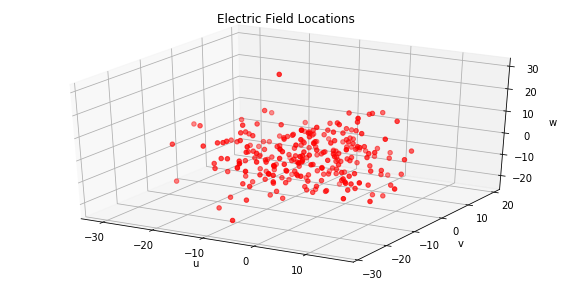

In [80]:
# Generate a gaussian cube
locations_gaussian = calculate_gaussian_volume_of_points(256)

us = locations_gaussian[:,0]
vs = locations_gaussian[:,1]
ws = locations_gaussian[:,2]
ax = plt.subplot(111, projection='3d')
ax.scatter(us,vs,ws, color='red')
ax.set_title('Electric Field Locations')
ax.set_xlabel('u'); ax.set_ylabel('v'); ax.set_zlabel('w')



In [81]:
locations_uvw = locations_gaussian/(wl/2)
u,s,vh = numpy.linalg.svd(locations_uvw)
print(s.shape)
for i in numpy.arange(locations_uvw.shape[-1]):
    print(numpy.max(locations_uvw[:,i]))
    print(numpy.min(locations_uvw[:,i]))
print(s)

(3,)
7.678359321164912
-15.316850385868833
9.29998387631719
-13.83683149501884
14.66173359409381
-11.252751677176567
[89.81025617 66.1263586  63.50689483]


In [84]:
#Plot locations

grid_locs = numpy.zeros(shape=(grid_size,grid_size))
location_grid_points = (2*locations_uvw + grid_size/2).astype(int)
location_grid_points[:,0] = location_grid_points[:,0] -0
location_grid_points[:,1] = location_grid_points[:,1] +
#print(location_grid_points)
for i in numpy.arange(location_grid_points.shape[0]):
    grid_locs[location_grid_points[i,0],location_grid_points[i,1]] += 1.0
    
plt.imshow(grid_locs)
plt.show()

IndexError: index 67 is out of bounds for axis 1 with size 64

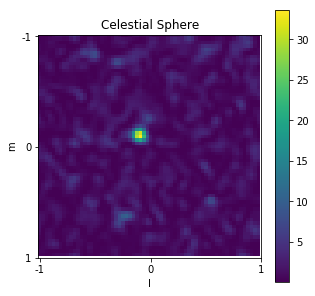

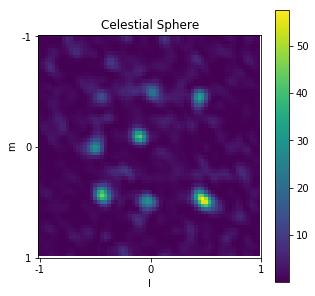

In [46]:
ee_gaussian_s = simulate_electric_fields(locations_uvw,numpy.asarray([[0.1,0.1,100],[-0.45,0.45,100],[0.45,0.45,100],[0.45,-0.45,100],[-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,100],[-0.5,0.0,100],[-0.5,-0.5,100]]))
ee_gaussian_sc = simulate_electric_fields_coplanar(locations_uvw,numpy.asarray([[0.1,0.1,100],[-0.45,0.45,100],[0.45,0.45,100],[0.45,-0.45,100],[-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,100],[-0.5,0.0,100],[-0.5,-0.5,100]]))
#ee_gaussian_s = simulate_electric_fields(locations_uvw,numpy.asarray([[0.0,0.0,100],[-0.1,-0.1,100],[0.0,-0.4,100]]))
#ee_gaussian_sc = simulate_electric_fields_coplanar(locations_uvw,numpy.asarray([[0.0,0.0,100],[-0.1,-0.1,100],[0.0,-0.4,100]]))
image3d = epic_image_snapshot(ee_gaussian_s,location_grid_points) # 3D 
plot_celestial_sphere(image3d)
image2d = epic_image_snapshot(ee_gaussian_sc,location_grid_points) # Coplanar Array
plot_celestial_sphere(image2d)

## Try computing with the DFT to make sure we're still on the right line.

In [55]:
def epic_image_dft(efield,locations):
    
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    for lg in numpy.arange(grid_size):
        
        lv = (1.0 / (0.5*grid_size)) * (lg - grid_size/2)
        #print(lv)
        for mg in numpy.arange(grid_size):
            mv = (1.0/ (0.5*grid_size)) * (mg - grid_size/2)
            if (lv**2 + mv**2 > 1.0):
                nv = 0
            else:
                nv = 1.0 - numpy.sqrt(1.0 - lv**2 - mv**2)
            #print(nv)
            for j,efieldd in enumerate(efield):
                u = locations[j,0]
                v = locations[j,1]
                w = locations[j,2]
                #w = 0
                image[lg,mg] += efieldd * numpy.exp(2j*numpy.pi*(u*lv + v*mv + w*nv))
    return image / (grid_size**2)


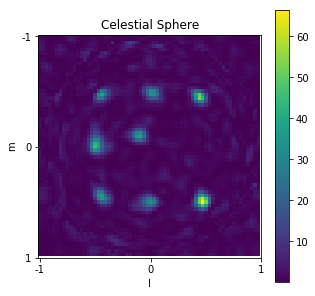

In [56]:
im = epic_image_dft(ee_gaussian_s,locations_uvw)
imcg = im * im.conj()
plot_celestial_sphere(imcg)

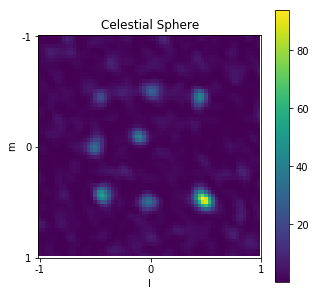

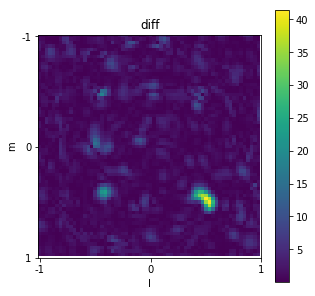

In [57]:
locations_uvwc = locations_uvw.copy()
locations_uvwc[:,2] = 0.0
im = epic_image_dft(ee_gaussian_sc,locations_uvwc)
imc = im * im.conj()
plot_celestial_sphere(imc)
plot_celestial_sphere(imcg-imc,title='diff')

DFT Looks good, let's do this the easy way with W-Stacking (or W-Projection kernels get ridiculous)

(Sorry Steve)

In [58]:
wstack_delta = 1.0
wmax = wstack_delta/2
size=5
# Stealing Peter's code makes life easier.
def recommended_size(eps=0.01):
    usupp = numpy.sqrt((wmax*theta/2)**2 + (wmax**1.5 * theta / 2 / numpy.pi / eps))
    return 2 * theta * usupp
def recommended_diff(eps):
    return abs(recommended_size(eps) - size)

print("w range:        %.3f - %.3f lambda" % (-wmax, wmax))
print("Kernel size:    %d px (> %.3f recommended)" % (size, recommended_size()))
print("Expected error: %f %%" % (100 * scipy.optimize.minimize(recommended_diff, 0.0001, bounds=[(1e-10,1)]).x))

w range:        -0.500 - 0.500 lambda
Kernel size:    5 px (> 13.567 recommended)
Expected error: 8.574441 %


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


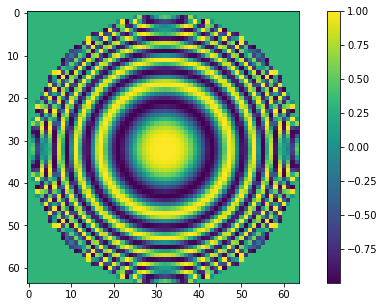

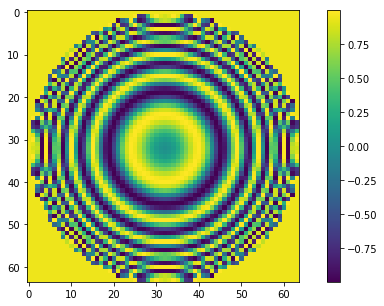

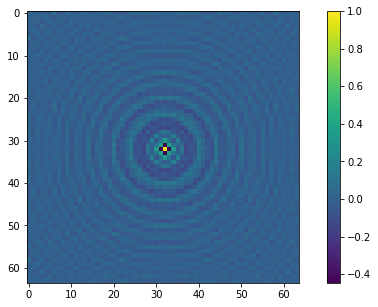

In [59]:
#Write our versions of these. I guess Bojan never thought people would be crazy enough to do horizon-to-horizon images!
def my_w_kernel_function(l, m, w):
    
    r2 = l**2 + m**2
    r2v = r2 > 1
    #print(r2v)
    #r2[r2v] = 1.0
    
    ph = 1.0 - numpy.sqrt(1.0 - r2)
    cp = numpy.exp(2j * numpy.pi * w * ph)
    cp[r2v] = numpy.exp(2j*numpy.pi * w)
    return cp

def w_kern(theta, w, NpixFF, NpixKern, Qpx, invert=True,**kwargs):
    assert NpixFF > NpixKern or (NpixFF == NpixKern and Qpx == 1)

    l,m = kernel_coordinates(NpixFF, theta, **kwargs)
    #l,m = theta * coordinates2(NpixFF)
    kern = my_w_kernel_function(l,m,w)
    if invert:
        kern = 1 / kern
    krn = kernel_oversample(kern, Qpx, NpixKern)
    return krn
    
def generate_fresnel(theta,lam,dw):
    grid_size = int(theta * lam)
    ls,ms = theta*coordinates2(grid_size) 
    
    return my_w_kernel_function(ls,ms,dw)

def wide_field_wkernel(theta,lam,dw):
    grid_size = int(theta * lam)
    frnl = generate_fresnel(theta,lam,dw)
    plt.imshow(frnl.real)
    plt.colorbar()
    plt.show()
    plt.imshow(frnl.imag)
    plt.colorbar()
    plt.show()
    frnl_f = numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.fftshift(frnl)))
    frnl_f = frnl_f/numpy.max(frnl_f)
    plt.imshow(frnl_f.real)
    
    plt.colorbar()
    plt.show()
    

def kernel_correction(theta,lam,size):
    grid_size = int(theta*lam)
    grid = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    gc = grid_size//2
    gclb = int(gc - size//2)
    gcub = int(gc + size//2)+1

    grid[gclb:gcub,gclb:gcub] = 1.0
    grid = numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.fftshift(grid)))
    return grid

wide_field_wkernel(theta,lam,8.2)

(64, 64)


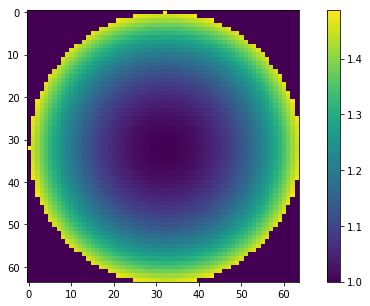

In [68]:
def anti_aliasing_function(shape, m, c):
        if len(numpy.array(shape).shape) == 0:
            mult = 2 - 1/shape/4
            return scipy.special.pro_ang1(m, m, c, mult*coordinates(shape))[0]
        return numpy.outer(anti_aliasing_function(shape[0], m, c),
                           anti_aliasing_function(shape[1], m, c))
    
    
aaf = 1/anti_aliasing_function((grid_size,grid_size),0,numpy.pi/2)
l,m = kernel_coordinates(grid_size, theta)
r2 = l**2 + m**2
r2v = r2 >1
aaf[r2v] = 1.0
print(r2v.shape)
plt.imshow(aaf)
plt.colorbar()
plt.show()

Max W:  6.084887977717536
Min W:  -7.425302634047568
W Range:  13.510190611765104
Number of W Planes:  1352.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


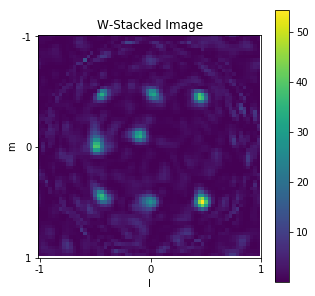

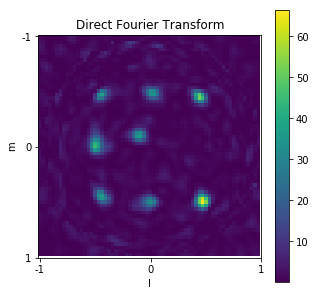

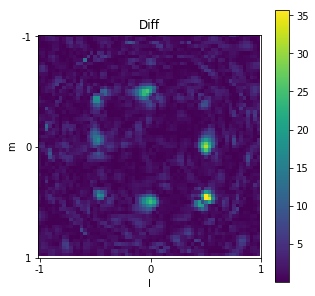

In [76]:
## Notes:
# W-Kernel is definitely not right. Understand why.
def epic_wstacking(theta,lam,locations, efieldf,dw):
    #print(w_kernel[0,0,:,:])
    grid_size = int(theta*lam)
    #w_kernel = w_kern(theta,dw,NpixFF=256,NpixKern=size,Qpx=8, invert=True)
    #wkh = w_kernel.shape[2]//2
    max_w = numpy.max(locations[:,2])
    min_w = numpy.min(locations[:,2]) 
    w_range = max_w - min_w
    w_planes = numpy.ceil(w_range/(dw)) 
    
    
    print("Max W: ",max_w)
    print("Min W: ",min_w)
    print("W Range: ",w_range)
    print("Number of W Planes: ",w_planes)
    
    
    #Fresnel Pattern
    fresnel_pattern = numpy.fft.fftshift(generate_fresnel(theta,lam,dw))

    #Setup W-Stacks
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    grid = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    conti = 0
    for i in numpy.arange(0,w_planes):
        if(i == 0):
            pass
        else:
            grid = numpy.fft.fftshift(numpy.fft.fft2(image))
        wpi = i - w_planes//2 
        wc = wpi*dw # Gives us our central w-value, so we know which electric field contributions belong to us.
        w_ub = wc + dw/2
        w_lb = wc - dw/2

        # Let's work out which contributions to put on each plane of the W-Stack.
        for j,efield in enumerate(efieldf):
            #print(efield)
            u = locations[j,0]
            v = locations[j,1]
            w = locations[j,2]
            #print(grid)
            if ((w > w_lb) and (w < w_ub)):
                #print("Cont: ",conti)
                #conti += 1
                ulo = 2*u + grid_size/2
                vlo = 2*v + grid_size/2
                u_loc = int(ulo)
                v_loc = int(vlo)
                #TODO: Oversample Kernels Correctly
                
                # Boxcar gridding so I can work out wtf is going on here.
                grid[v_loc,u_loc] += efield
        
        image = numpy.fft.ifft2(numpy.fft.fftshift(grid))    
        image /= fresnel_pattern

        
    return numpy.fft.fftshift(image*(fresnel_pattern**(w_planes//2)))



#for wval in numpy.arange(1.0,5.0,0.025):
image_wsg = epic_wstacking(theta,lam,locations_uvw,ee_gaussian_s,0.01)
image_wsi = (image_wsg * image_wsg.conj())

gc_im = aaf*image_wsi.T
plot_celestial_sphere(gc_im,title='W-Stacked Image')
plot_celestial_sphere(imcg,title='Direct Fourier Transform')
plot_celestial_sphere(gc_im-imcg.T,title='Diff')


In [64]:
vis_efield = numpy.outer(ee_gaussian_s,ee_gaussian_s.T)
print(vis_efield.shape)

(256, 256)


Easy peasy. Non-Coplanarity correction with EPIC is exactly the same as with visibilities. 

This is of course obvious as one is derived from the other, but this should hopefully placate the naysayers. 

In [31]:
#Image directly from image routines using the EPIC formalism.

def epic_image(efield,locations):
    grid = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex64)
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex64)    
    location_grid_points = locations

    for j,efieldd in enumerate(efield):
        for i,e_sample in enumerate(efieldd[:,0]):
            #print("Sample: %d"%i)
            grid[location_grid_points[i,0],location_grid_points[i,1]] += e_sample

        imaged = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid),s=(grid_size,grid_size)))
        imaged = imaged * imaged.conj()
        #plt.imshow(numpy.abs(imaged))
        #plt.colorbar()
        #plt.show()
        
        
        
        image += imaged
        grid[...] = 0.0
            
    #plt.imshow(grid.real)
    #plt.show()
    #image = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.fftshift(grid)))
    #imsq = image * image.conj()
    #print("Aah")
    plt.imshow(numpy.abs(image/efield.shape[0]))
    plt.colorbar()
    plt.show()
    

#### Optimal Gridding

Let's do things a la Sze Tan and co. Optimal kernels are already generated.

Using Sze-Tan's gridder with R=4, x_0=0.25
Mean error: 1.1790551575392398e-08
Optimal du = 0.25


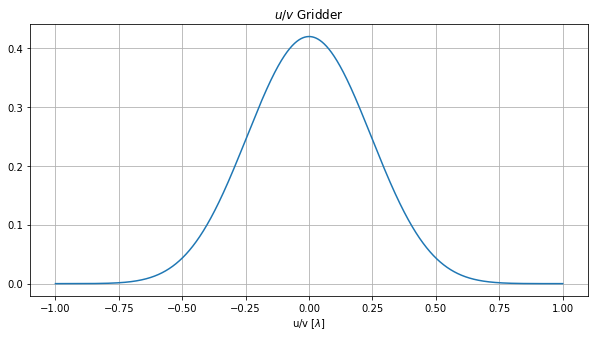

(10001,)


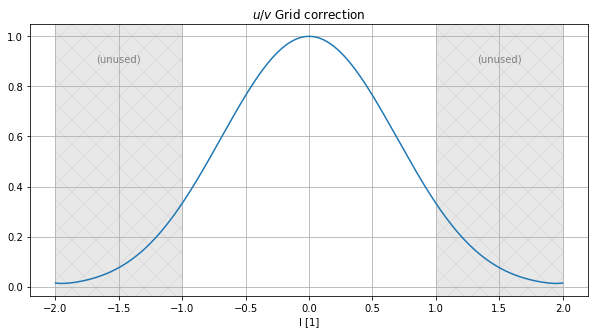

In [32]:
aa_over = 4096
aa_support = 8
aa_x0 = 0.25
aa_mode = 0
aa_szetan = True
if aa_support == 1:
    print("Using trivial gridder")
    aa_gcf = numpy.ones((aa_over, aa_support))
    def aa(x): return numpy.ones_like(x)
elif aa_szetan:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support//2, aa_x0))
    aa_gcf = sze_tan_gridder(aa_support//2, aa_x0, aa_over)
    def aa(x):
        return sze_tan_grid_correction_gen(aa_support//2, aa_x0, x)
    print("Mean error:", sze_tan_mean_error(aa_support//2, aa_x0))
else:
    aa_parameter = aa_support
    print("Using PSWF with mode %d and parameter %g" % (aa_mode, aa_parameter))
    aa_gcf = kernel_oversample(anti_aliasing_function(grid_size, aa_mode, aa_parameter), aa_over, aa_support)
    aa_gcf /= numpy.sum(aa_gcf[0])
    def aa(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter, 2*x)[0]
    
# Calculate appropriate step length to give us full accuracy for a field of view of size theta
du = du_opt = aa_x0/(theta/2)
print("Optimal du =", du)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support//2), aa_over*((aa_support+1)//2)) / aa_over
plt.plot(du_opt*r, numpy.transpose(aa_gcf).flatten().real);
plt.xticks(du_opt*numpy.arange(-(aa_support//2), ((aa_support+1)//2)+1))
plt.grid(True);plt.xlabel('u/v [$\lambda$]');plt.title('$u/v$ Gridder');plt.show()

# Plot grid correction function
theta_x0 = theta/aa_x0/2
x = coordinates(10001)
#print(x)
sze_aa_im = aa(x)
print(sze_aa_im.shape)
plt.plot(theta*x/aa_x0/2, aa(x));
plt.title('$u/v$ Grid correction');plt.grid(True);plt.xlabel('l [1]')
plt.axvspan(theta/2, theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-theta/2, -theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((theta+theta_x0)/4,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(theta+theta_x0)/4,0.9), ha='center', color='gray');

Using Sze-Tan's gridder with R=2, x_0=0.125
Mean error: 7.125787071239688e-06
max_n = 1.0
Optimal dw = 0.125


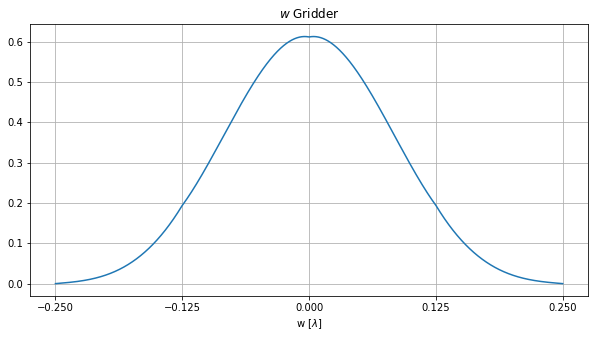

[-0.49995    -0.49985001 -0.49975002 ...  0.49975002  0.49985001
  0.49995   ]
[0.23630141 0.23607546 0.23585053 ... 0.23585053 0.23607546 0.23630141]


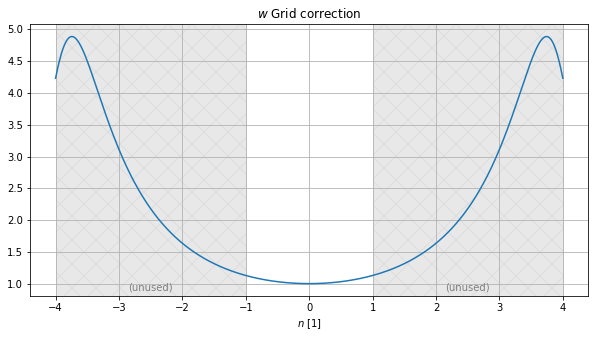

In [33]:
aa_support_w = 4
aa_x0_w = 0.125
aa_parameter_w = aa_support_w
aa_szetan_w = True
if aa_support_w == 1:
    print("Using trivial gridder")
    aa_gcf_w = numpy.ones((aa_over, aa_support_w))
    def aa_w(x): return numpy.ones_like(x)
elif aa_szetan_w:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support_w//2, aa_x0_w))
    aa_gcf_w = sze_tan_gridder(aa_support_w//2, aa_x0_w, aa_over)
    def aa_w(x):
        return sze_tan_grid_correction_gen(aa_support_w//2, aa_x0_w, x)
    print("Mean error:", sze_tan_mean_error(aa_support_w//2, aa_x0_w))
else:
    aa_gcf_w = kernel_oversample(anti_aliasing_function(grid_size, 0, aa_parameter_w), aa_over, aa_support_w)
    aa_gcf_w /= numpy.sum(aa_gcf_w[0])
    def aa_w(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter_w, 2*x)[0]

# Calculate appropriate step length to give us full accuracy for a field of view of size theta
max_n = 1.0
print("max_n =", max_n)
dw = dw_opt = aa_x0_w / max_n
print("Optimal dw =", dw)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support_w//2), aa_over*((aa_support_w+1)//2)) / aa_over
plt.plot(dw_opt*r, numpy.transpose(aa_gcf_w).flatten().real);
plt.xticks(dw_opt*numpy.arange(-(aa_support_w//2), ((aa_support_w+1)//2)+1))
plt.grid(True); plt.xlabel('w [$\lambda$]'); plt.title('$w$ Gridder'); plt.show()

x = coordinates(10001)
print(x)
sze_w_im = aa_w(x)
print(sze_w_im)
#plt.plot(max_n*x/aa_x0_w, aa_w(x));
plt.plot(max_n*x/aa_x0_w, 1/aa_w(x));
plt.title('$w$ Grid correction'); plt.grid(True); plt.xlabel('$n$ [1]');
max_n_x0 = max_n/aa_x0_w/2
plt.axvspan(max_n, max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-max_n, -max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((max_n+max_n_x0)/2,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(max_n+max_n_x0)/2,0.9), ha='center', color='gray');

In [34]:
max_w = numpy.sin(theta/2) * numpy.sqrt(grid_size**2 + grid_size**2)
max_w = numpy.max(locations_uvw[:,2]) - numpy.min(locations_uvw[:,2])
w_planes = 2*numpy.ceil(max_w/(2*dw)) + aa_support_w

print("Stacking Parameters: ")
print(max_w)
print(w_planes)

Stacking Parameters: 
27.802980667936808
228.0


In [35]:
# Generating a fresnel pattern for such a large field of view is problematic...
def generate_fresnel_x0(theta,lam,dw,x0):
    grid_size = int(theta*lam)
    x0ih = 0.5/x0
    oversampg = x0ih * grid_size
    print(oversampg)
    grid_size = int(theta * lam)
    ls,ms = theta*coordinates2(x0ih*grid_size)
    r2 = ls**2 + ms**2
    r2[r2>1.0] = 0.0
    ns = numpy.sqrt(1 - r2) - 1.0
    ns = numpy.nan_to_num(ns)
    
    #Fresnel Pattern
    
    ph = 1 - numpy.sqrt(1.0 -r2)
    frnl = numpy.exp(2j * numpy.pi * dw * ph)
    
    return(frnl)

generate_fresnel_x0(theta,lam,dw_opt,aa_x0)

128.0


array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]])

In [78]:
# Prove it for a snapshot first.
# Also extend to Y polarisation too!
#def epic_wstack(theta,lam,efield,locations,x0,du=du_opt,dw=dw_opt,
#                gcf_support=aa_gcf,gcf_support_w=aa_gcf_w, aa=aa, aa_w=aa_w):
#    
#    grid_size = int(theta*lam)
#    #max_w = numpy.sin(theta/2) * numpy.sqrt(grid_size**2 + grid_size**2)
#    max_w = numpy.max(locations[:,2]) - numpy.min(locations[:,2]) 
#    w_planes = 2*numpy.ceil(max_w/(2*dw)) + aa_support_w
#    w_min = numpy.min(locations[:,2])
#    #Fresnel Pattern
##    fresnel_pattern = generate_fresnel_x0(theta,lam,dw,x0)
#    
#    # W-Stacking
#    wstacks = numpy.zeros(shape=(int(w_planes),2*grid_size,2*grid_size),dtype=numpy.complex128)
#    image = numpy.zeros(shape=(2*grid_size,2*grid_size),dtype=numpy.complex128)
#    
#    # Crude Plane based binning (based on assumption memory cost not too high)
#    #locations[:,0:1] /= du
#    #locations[:,2] /= dw
##    locations[:,0:2] += grid_size
#    locations[:,0] -= 10
#    locations[:,1] -= 10
#    print(locations)
    
    
    # First distribute our electric field contributions to the
    # appropriate W-Stack.
    # (Alternatively could book-keep binning, but this doesn't cost
    # too much memory for our grid sizes)
#    image_accum = numpy.zeros((2*grid_size,2*grid_size),dtype=numpy.complex128)
#    for j,efields in enumerate(efield):
                
            
#        u = locations[j,0]
#        v = locations[j,1]
#        w = locations[j,2]
#        #print(grid)
#        if ((w > w_lb) and (w < w_ub)):
#            #print("Cont: ",conti)
#            #conti += 1
#            ulo = 2*u + grid_size/2
#            vlo = 2*v + grid_size/2
#            u_loc = int(ulo)
#            v_loc = int(vlo)
#                #TODO: Oversample Kernels Correctly
#                
#            # Boxcar gridding so I can work out wtf is going on here.
#            grid[v_loc,u_loc] += efield
#            
#            
#                       
#            u = location[0]
#            v = location[1]
#            w = location[2]
#            wpi = int((w-w_min)//dw + 0.5)
#            #print("Locations: u: %f v: %f w: %f"%(u,v,w))
#            #print("WPlane: %d"%(wpi))
#        
#            #Calculate oversampling values.   
#            wpio = numpy.floor((abs(w)/dw-(abs(w)//dw))*aa_over).astype(int)
#            uio = numpy.floor((abs(u)/du-(abs(u)//du))*aa_over).astype(int)
#            vio = numpy.floor((abs(v)/du-(abs(v)//du))*aa_over).astype(int)
#        
#       
#            #print(uio)
#            #print(vio)
#            #print(wpio)
#        
#            wp_max = wpi + aa_support_w/2
#        
#            for wplane in numpy.arange(0,aa_support_w):           
#                wpii = int(wpi + wplane - aa_support_w/2)
#                for ui in numpy.arange(0,aa_support):
#                    uii = int(ui + u - aa_support/2)
#                    for vi in numpy.arange(0, aa_support):
#                        vii = int(vi + v - aa_support/2)
#                        aas = aa_gcf[uio,ui] * aa_gcf[vio,vi] * aa_gcf_w[wpio,wplane]
#                    
#                        wstacks[wpii,uii,vii] += efields[i,0] * aas
#                    
#                    
#        # Run the Imager W-Stacking Algorithm
#    
#        image = numpy.zeros((2*grid_size,2*grid_size),dtype=numpy.complex128)
#        wstacks = numpy.fft.fftshift(wstacks,axes=(1,2))
#        fps = numpy.fft.fftshift(fresnel_pattern)
#        for wplane in wstacks:
#        
#            image += wplane
#            image = numpy.fft.ifft2(image)
#            image *= fps
#            image = numpy.fft.fft2(image)
#    
#        image = numpy.fft.fftshift(numpy.fft.ifft2(image))
#    
#        imaged = image * image.conj()
#        image_accum += imaged
#    plt.imshow(image_accum.real)
#    plt.colorbar()
#    plt.show()
#                    
#epic_wstack(theta,lam,ee_gaussian_s,locations_uvw.copy(),aa_x0)    